### Import lib

In [2]:
import json
import pickle
import random
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns


import nltk  
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,f1_score,average_precision_score,recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.pipeline import Pipeline 


import spacy
from bs4 import BeautifulSoup
import unicodedata
import string


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading BOT configuration file

In [3]:
bot_config_file = open("GL_Bot.json")
bot_config_data = json.load(bot_config_file)
bot_config_data["intents"][0]

{'tag': 'Intro',
 'patterns': ['hi',
  'how are you',
  'is anyone there',
  'hello',
  'whats up',
  'hey',
  'yo',
  'listen',
  'please help me',
  'i am learner from',
  'i belong to',
  'aiml batch',
  'aifl batch',
  'i am from',
  'my pm is',
  'blended',
  'online',
  'i am from',
  'hey ya',
  'talking to you for first time'],
 'responses': ['Hello! how can i help you ?'],
 'context_set': ''}

### Processing the BOT Configure file

In [4]:
lem = nltk.stem.wordnet.WordNetLemmatizer()

def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def to_lowercase(text):
    return text.lower()

def get_lem(text):
    text = ' '.join([lem.lemmatize(word) for word in text.split()])
    return text


def text_processing(text):
    text = to_lowercase(text)
    text = remove_accented_chars(text)
    text = remove_special_characters(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespace_tabs(text)
    text = get_lem(text)
    return text

In [5]:
### Build Unique words , tag, document - tag linkage, tag- response linkage

unique_words = []
tags = []
document_tag = []
tag_response = {}
document = []

for intents in  bot_config_data["intents"]:
    tag_value = to_lowercase(intents["tag"])
    response = intents["responses"][0]
    patterns_list = intents["patterns"]
    for pattern in patterns_list:
        text = text_processing(pattern)
        document.append(text)
        text_tokens = nltk.word_tokenize(text)        
        document_tag.append((tag_value,text))
        unique_words.extend(text_tokens)
        tags.append(tag_value)
    tag_response[tag_value] = response

unique_words = list(set(unique_words))    

In [6]:
print("Total unique words -- " , len(unique_words), unique_words)
print("--------------")
print("Total document -- ", len(document_tag),document_tag)
print("--------------")
print("Total tags -- ", len(set(tags)) , set(tags))

Total unique words --  158 ['i', 'helped', 'gradient', 'there', 'hate', 'learning', 'day', 'hi', 'am', 'backward', 'cross', 'jerk', 'thank', 'talking', 'listen', 'function', 'classification', 'aifl', 'operation', 'hidden', 'ml', 'bloody', 'technique', 'anyone', 'bot', 'please', 'have', 'useless', 'able', 'sigmoid', 'hour', 'great', 'later', 'sl', 'think', 'shit', 'did', 'who', 'not', 'pm', 'ticket', 'no', 'hyper', 'hell', 'naive', 'whats', 'aiml', 'net', 'explain', 'help', 'bagging', 'is', 'you', 'network', 'olympus', 'relu', 'forward', 'what', 'my', 'bayes', 'work', 'lot', 'when', 'problem', 'good', 'softmax', 'to', 'propagation', 'are', 'tool', 'intelligence', 'sgd', 'solved', 'joke', 'of', 'activation', 'contact', 'ya', 'leaving', 'layer', 'your', 'batch', 'blended', 'stupid', 'adam', 'goodbye', 'up', 'piece', 'learner', 'do', 'techbniques', 'otimizer', 'too', 'thanks', 'in', 'weight', 'name', 'olypus', 'boosting', 'understand', 'opertions', 'window', 'ton', 'supervised', 'teach', '

### prepare word occurrence matrix

In [7]:
bow_vector = CountVectorizer(stop_words = None)
tdf = bow_vector.fit_transform(document)
X = pd.DataFrame(np.where(tdf.toarray()>=1,1,0), columns = bow_vector.get_feature_names())
X

,able,access,activation,ada,adam,aifl,aiml,am,an,ann,...,who,whom,window,with,work,working,ya,yo,you,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### encode the Tags

In [8]:
label_encoder = LabelBinarizer()
y = label_encoder.fit_transform(tags)
y.shape

(128, 8)

### train / test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 39)

print("X_train Shape",X_train.shape)
print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)
print("y_test Shape",y_test.shape)

X_train Shape (115, 156)
y_train Shape (115, 8)
X_test Shape (13, 156)
y_test Shape (13, 8)


### Train NN model for the classification


In [10]:

model = Sequential()
model.add(Dense(128, input_shape=(X.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss',patience=10,min_delta=0.0001)
fit_data = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,batch_size=1, verbose=1,callbacks=[es])


Epoch 1/200
115/115 [==============================] - 2s 11ms/step - loss: 2.0032 - accuracy: 0.2273 - val_loss: 2.2098 - val_accuracy: 0.1538
Epoch 2/200
115/115 [==============================] - 0s 1ms/step - loss: 1.6852 - accuracy: 0.4089 - val_loss: 2.2224 - val_accuracy: 0.2308
Epoch 3/200
115/115 [==============================] - 0s 1ms/step - loss: 1.7120 - accuracy: 0.3889 - val_loss: 2.0858 - val_accuracy: 0.2308
Epoch 4/200
115/115 [==============================] - 0s 2ms/step - loss: 1.5976 - accuracy: 0.4107 - val_loss: 1.6661 - val_accuracy: 0.3846
Epoch 5/200
115/115 [==============================] - 0s 1ms/step - loss: 1.5036 - accuracy: 0.5420 - val_loss: 2.3694 - val_accuracy: 0.2308
Epoch 6/200
115/115 [==============================] - 0s 1ms/step - loss: 1.3823 - accuracy: 0.4751 - val_loss: 1.7059 - val_accuracy: 0.2308
Epoch 7/200
115/115 [==============================] - 0s 1ms/step - loss: 2.4104 - accuracy: 0.2977 - val_loss: 1.9282 - val_accuracy: 0.153

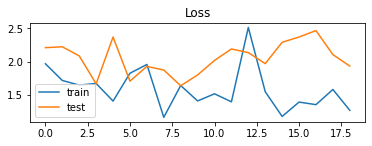

In [11]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(fit_data.history['loss'], label='train')
plt.plot(fit_data.history['val_loss'], label='test')
plt.legend()
plt.show()

### OneVsRestClassifier with LinearSVC  

In [13]:
svc = LinearSVC()
svc_pipeline = Pipeline([("classifier", OneVsRestClassifier(svc))])

svc_pipeline.fit(X_train,y_train)

print("Train accuracy - ", svc_pipeline.score(X_train,y_train))
y_predict = svc_pipeline.predict(X_test)

print("Test accuracy --",round(accuracy_score(y_test,y_predict),2))

Train accuracy -  1.0
Test accuracy -- 0.23


In [30]:
### Chatboot code
continue_dialogue = True
print("Hello! how can i help you ?")
while(continue_dialogue):
    input_text = input()
    input_text = text_processing(input_text)
    word_matrix = bow_vector.transform([input_text])
    result = model.predict_classes([word_matrix])
    #print(result)
    predictedtag = label_encoder.classes_[result[0]]
    #print(predictedtag)
    response = tag_response[predictedtag]
    print(response)
    if(predictedtag == "exit"):
        continue_dialogue = False
    


Hello! how can i help you ?
your name please
I am your virtual learning assistant
ohh, how does random forest works ?
Link: Machine Learning wiki 
what is earlystopping in neural net
Link: Neural Nets wiki
wonderful :) thank you for your support
I hope I was able to assist you, Good Bye
